<a href="https://colab.research.google.com/github/EasonLi292/-/blob/master/program3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [ ]:
#define CNN
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # First convolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=3)

        # Second
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Third
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        # 10 classes.
        # The image size reduces to 4x4, and the number of channels is 256, so 4x4x256 = 4096.
        self.fc = nn.Linear(in_features=4096, out_features=10)

        # define max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        # Block 1: Convolution -> ReLU -> Max Pooling.
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)  # 16x16.

        # Block 2: Convolution -> ReLU -> Max Pooling.
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)  # 8x8.

        # Block 3: Two Convolutions -> ReLU -> Max Pooling.
        x = self.conv3_1(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = F.relu(x)
        x = self.pool(x)  # 4x4.

        # Flatten
        x = x.view(x.size(0), -1)  # x.size(0) is the batch size.
        x = self.fc(x)  # Outputs 10 values, one for each class.
        return x



In [ ]:
def main():
    # Check if a GPU is available; otherwise use CPU.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Define the transformation for the images:
    # Convert images to tensors and normalize pixel values.
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Download and load the CIFAR-10 training and test datasets.
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create data loaders to iterate over the datasets in batches.
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

    # Create an instance of the model and move it to the chosen device.
    model = BasicCNN().to(device)

    # Define the loss function and optimizer.
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification.
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer.

    # Variables to store training time and errors for each epoch.
    train_times = []
    train_errors = []
    test_errors = []
    num_epochs = 10  # You can change the number of epochs if desired.

    # Training loop.
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode.
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        start_time = time.time()

        for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)

            # Clear
            optimizer.zero_grad()

            # Forward
            outputs = model(images)

            loss = criterion(outputs, labels)

            # Compute gradients.
            loss.backward()

            # Update parameters.
            optimizer.step()

            # Update running loss and training accuracy.
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Data for the epoch.
        epoch_time = time.time() - start_time
        train_times.append(epoch_time)

        train_error = 1 - correct_train / total_train
        train_errors.append(train_error)

        # Evaluate the model on the test dataset.
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_error = 1 - correct_test / total_test
        test_errors.append(test_error)

        print(f"Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Error: {train_error:.4f}, Test Error: {test_error:.4f}")

    # training time/ epoch.
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_times, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time per Epoch')
    plt.show()

    # training vs testing errors.
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_errors, marker='o', label='Training Error')
    plt.plot(range(1, num_epochs+1), test_errors, marker='o', label='Testing Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title('Training & Testing Errors per Epoch')
    plt.legend()
    plt.show()


Using device: cuda


100%|██████████| 170M/170M [00:07<00:00, 22.8MB/s]


Epoch 1/10, Time: 15.71s, Train Error: 0.5018, Test Error: 0.4097
Epoch 2/10, Time: 14.29s, Train Error: 0.3160, Test Error: 0.2891
Epoch 3/10, Time: 14.71s, Train Error: 0.2448, Test Error: 0.2612
Epoch 4/10, Time: 14.75s, Train Error: 0.1947, Test Error: 0.2540
Epoch 5/10, Time: 13.76s, Train Error: 0.1520, Test Error: 0.2581
Epoch 6/10, Time: 14.25s, Train Error: 0.1143, Test Error: 0.2507
Epoch 7/10, Time: 14.81s, Train Error: 0.0841, Test Error: 0.2550
Epoch 8/10, Time: 14.17s, Train Error: 0.0668, Test Error: 0.2630
Epoch 9/10, Time: 14.09s, Train Error: 0.0593, Test Error: 0.2694
Epoch 10/10, Time: 14.61s, Train Error: 0.0551, Test Error: 0.2572


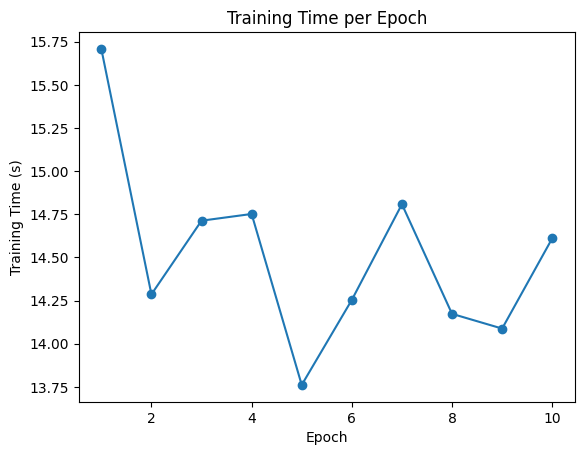

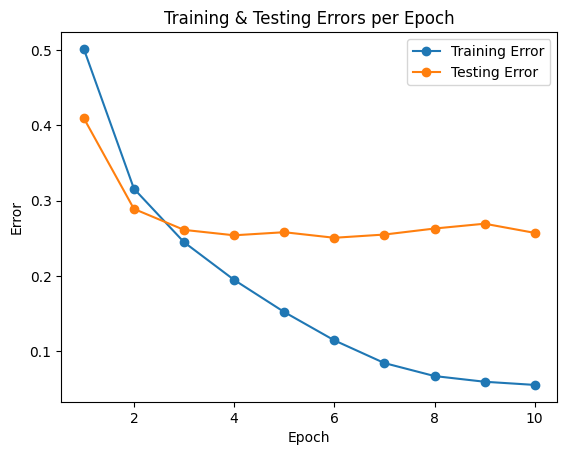

In [ ]:
if __name__ == "__main__":
  main()
